<a href="https://colab.research.google.com/github/Felipe-Oliveira11/Cars_Prediction_ML/blob/master/Text_Classification_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classificação de  Tweets 


<br>

In [65]:
import os 
import re
import string
import random 
import time 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, SpatialDropout1D
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dropout, GRU, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
path = '/content/drive/My Drive/Deep Learning - Projetos/Analise de Sentimentos Twitter /training.1600000.processed.noemoticon.csv'
data = pd.read_csv(path, encoding='latin', header=None)

In [3]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.drop(['id', 'date', 'query', 'user_id'], axis=1, inplace=True)

In [5]:
# label encoder 

label_sentiment = {0:'Negative', 4:'Positive'}

def label_decoder(label):
  return label_sentiment[label]


data.sentiment = data.sentiment.apply(lambda x: label_decoder(x))
data.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


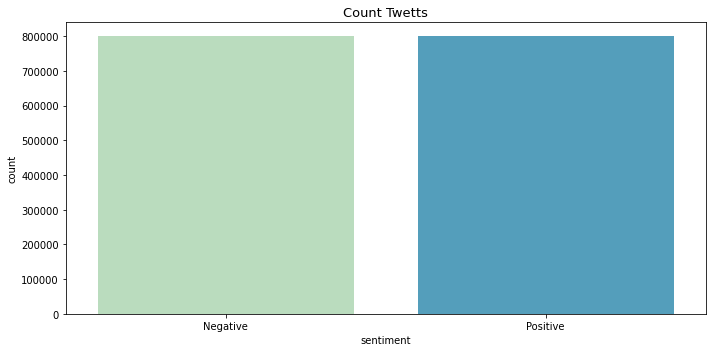

In [6]:
plt.figure(figsize=(10,5))
plt.title('Count Twetts', fontsize=13)
sns.countplot(data['sentiment'], palette='GnBu')
plt.tight_layout()

<br>
<hr>
<br>




### Text Preprocessing


* Stemming 
* Stopwords 



<br>

In [7]:
# visualize text
for index, text in enumerate(data['text'][10:14]):
  print('Review {}: \n {}'.format(index+1, text))

Review 1: 
 spring break in plain city... it's snowing 
Review 2: 
 I just re-pierced my ears 
Review 3: 
 @caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
Review 4: 
 @octolinz16 It it counts, idk why I did either. you never talk to me anymore 


In [8]:
# Stemmer and Stopwords
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [9]:
# preprocessing function 

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else: 
        tokens.append(token)
  return " ".join(tokens)

In [10]:
# aplicando 
data.text = data.text.apply(lambda x: preprocess(x))

In [11]:
data.text.head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

<br>
<hr>
<br>

### WordCloud

* Words Positives
* Words Negatives



<br>


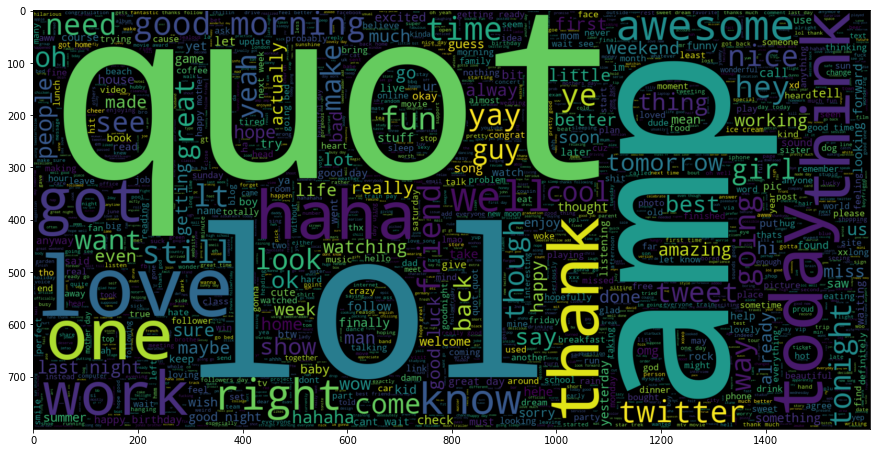

In [12]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data[data.sentiment == 'Positive']['text']))

plt.imshow(wc, interpolation='bilinear')

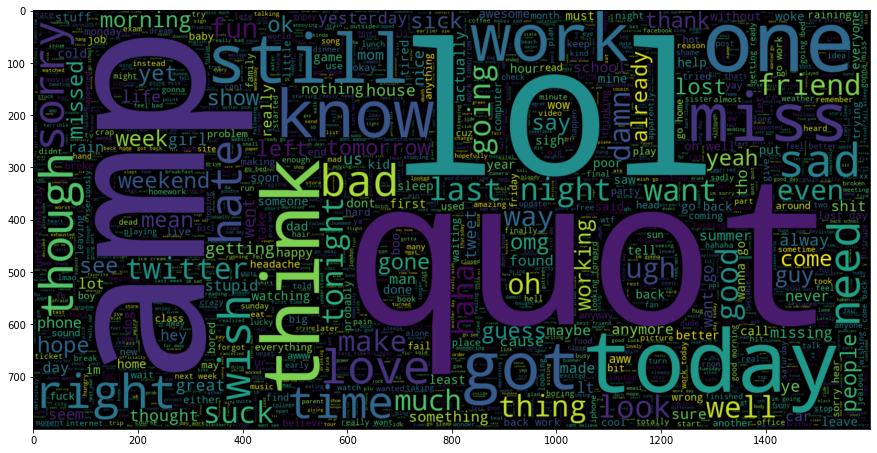

In [13]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(data[data.sentiment == 'Negative']['text']))

plt.imshow(wc, interpolation='bilinear')

<br>
<hr>
<br>


### Train-test 

<br>

In [14]:
train_data, test_data = train_test_split(data, test_size=0.30, random_state=42)

print('Train size: {}'.format(len(train_data)))
print('Test size: {}'.format(len(test_data)))

Train size: 1120000
Test size: 480000


In [15]:
train_data.head()

,sentiment,text
1064291,Positive,disnleyland tha happiest place tha world grad ...
281802,Negative,omg bellllyyy shoutin sum food brb soooo starv...
168792,Negative,still waiting find caca stands hoping think si...
911020,Positive,face
69604,Negative,sad see drive away wat


In [16]:
# Tokenization 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 
print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 266578


In [22]:
# Definir tokens de treino e teste 
sequence_train = tokenizer.texts_to_sequences(train_data.text)
sequence_test = tokenizer.texts_to_sequences(test_data.text)

In [23]:
# Determinar tamanho máximo de sequência 
max_sequence_lenght = 30 

X_train = pad_sequences(sequence_train, maxlen=max_sequence_lenght, padding='pre')
X_test = pad_sequences(sequence_test, maxlen=max_sequence_lenght, padding='pre')


print('Maior Sequência: {}'.format(len(max(data.text))))
print('Sequência Determinada: {}'.format(max_sequence_lenght))

Maior Sequência: 58
Sequência Determinada: 30


In [18]:
# LabelEncoder 

labels = train_data.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(data.sentiment)

y_train = encoder.transform(train_data.sentiment.to_list())
y_test  = encoder.transform(test_data.sentiment.to_list())


y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1120000, 1)
y_test shape: (480000, 1)


<br>
<hr>
<br>



### Word Embeddings 

Vamos usar um Embedding pré-treinado chamado <b>GloVe Embedding from Stanford AI</b> da Universidade de Stanford
 
<br>

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-08-28 16:40:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-28 16:40:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-28 16:40:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [31]:
# definindo hiperparâmetros 

GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300 

In [32]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Encontrado {} vetores de palavras.'.format(len(embeddings_index)))

Encontrado 400000 vetores de palavras.


In [37]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

<br>
<hr>
<br>


### Construção LSTM 


<br>

In [54]:
model = Sequential()
model.add(Input(shape=(max_sequence_lenght)))
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=max_sequence_lenght,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(LSTM(units=64, dropout=0.20, recurrent_dropout=0.20))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=1, activation='sigmoid'))


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           79973400  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

In [58]:
optimizer = Adam(learning_rate=0.001)
loss = BinaryCrossentropy(from_logits=True)
metrics = ['accuracy']


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [60]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
1094/1094 [==============================] - 860s 786ms/step - loss: 0.6311 - accuracy: 0.7026 - val_loss: 0.6168 - val_accuracy: 0.7397
Epoch 2/10
1094/1094 [==============================] - 854s 780ms/step - loss: 0.6196 - accuracy: 0.7336 - val_loss: 0.6157 - val_accuracy: 0.7570
Epoch 3/10
1094/1094 [==============================] - 859s 785ms/step - loss: 0.6161 - accuracy: 0.7430 - val_loss: 0.6119 - val_accuracy: 0.7476
Epoch 4/10
1094/1094 [==============================] - 856s 782ms/step - loss: 0.6139 - accuracy: 0.7478 - val_loss: 0.6110 - val_accuracy: 0.7558
Epoch 5/10
1094/1094 [==============================] - 846s 773ms/step - loss: 0.6122 - accuracy: 0.7526 - val_loss: 0.6100 - val_accuracy: 0.7547
Epoch 6/10
1094/1094 [==============================] - 847s 774ms/step - loss: 0.6109 - accuracy: 0.7557 - val_loss: 0.6104 - val_accuracy: 0.7650
Epoch 7/10
1094/1094 [==============================] - 856s 783ms/step - loss: 0.6101 - accuracy: 0.7579 - val_

In [61]:
loss, accuracy = model.evaluate(X_test, y_test)

15000/15000 [==============================] - 168s 11ms/step - loss: 0.6085 - accuracy: 0.7631


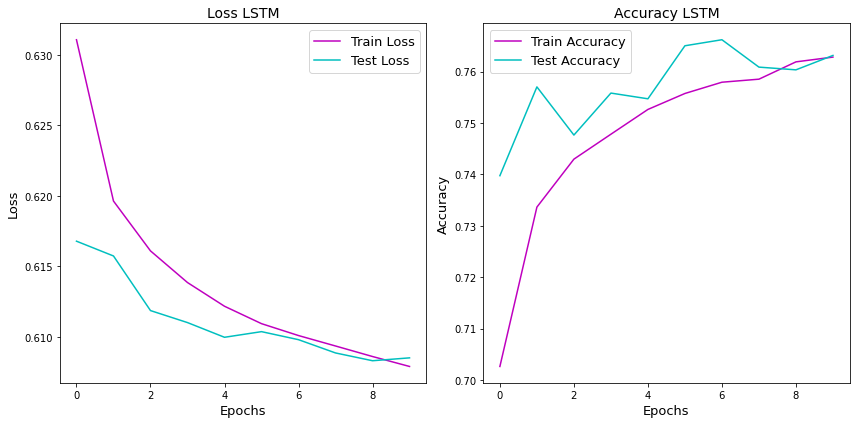

In [67]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(history.epoch, history.history['loss'], color='m', label='Train Loss')
ax[0].plot(history.epoch, history.history['val_loss'], color='c', label='Test Loss')
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].set_title('Loss LSTM', fontsize=14)
ax[0].legend(fontsize=13)


ax[1].plot(history.epoch, history.history['accuracy'], color='m', label='Train Accuracy')
ax[1].plot(history.epoch, history.history['val_accuracy'], color='c', label='Test Accuracy')
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Accuracy', fontsize=13)
ax[1].set_title('Accuracy LSTM', fontsize=14)
ax[1].legend(fontsize=13)



plt.tight_layout()
plt.show()